<a href="https://colab.research.google.com/github/liliya-ily/cat_autoencoder/blob/main/cat_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# В данном проекте используется сравнение архитектуры на базе свёрточных слов без Conv2DTranspose и с Conv2DTranspose

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Импортируются необходимые библиотеки

In [ ]:
from glob import glob
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, 
                                    UpSampling2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import cv2 as cv
import matplotlib.pyplot as plt

## Скачивание данных с kaggle.com

In [ ]:
# ! pip install -q kaggle

In [ ]:
# from google.colab import files

In [ ]:
# files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lilyily","key":"81676af7d82503252c257212cf373319"}'}

In [ ]:
# ! mkdir ~/.kaggle

In [ ]:
# ! cp kaggle.json ~/.kaggle/

In [ ]:
#  !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
# !kaggle datasets download -d crawford/cat-dataset

100% 4.02G/4.04G [01:25<00:00, 25.7MB/s]
100% 4.04G/4.04G [01:25<00:00, 50.5MB/s]


In [ ]:
# ! unzip /content/cat-dataset.zip -d kaggle 

In [ ]:
# !rm -f /content/PetImages/Cat/15*
# !rm -f /content/PetImages/Cat/13*
# !rm -f /content/PetImages/Cat/12*
# !rm -f /content/PetImages/Cat/16*
# !ls /content/kaggle/CAT_00

In [ ]:
# os.listdir('/content/kaggle/CAT_00')

In [ ]:
# os.listdir('/content/kaggle/cats')

['CAT_04', 'CAT_05', 'CAT_03', 'CAT_01', 'CAT_06', 'CAT_00', 'CAT_02']

## Подготовка изображений

In [ ]:
def img_preprocess():
    img_list = []

    for img_path in glob('/content/kaggle/CAT_00/*.jpg'):
        img = cv.imread(img_path)            # cv - 3-мерный массив, last_channel = 3, трехэлементный цвет RGB.
        img = cv.resize(img, (224, 224))     # Преобразование формы в (224, 224)
        sc_img = img.astype('float') / 255   # Нормализация
        img_list.append(sc_img)
    
    return np.asarray(img_list)

In [ ]:
img_arr = img_preprocess()

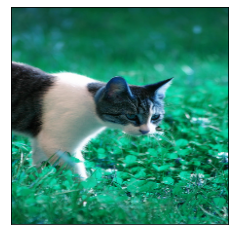

In [97]:
plt.imshow(img_arr[15]);
plt.xticks([]);
plt.yticks([]);

In [ ]:
img_arr.shape

(1706, 224, 224, 3)

##Построение модели
##Convolutional AutoEncoder

In [98]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(filters=64, kernel_size=(3,3),
           padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2,2),
                 strides=(2,2))(x)
x = Conv2D(filters=32, kernel_size=(3,3),
           padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2),
                 strides=(2,2))(x)
x = Conv2D(filters=32, kernel_size=(3,3),
           padding='same', activation='relu')(x)
encoder_layer = MaxPooling2D(pool_size=(2,2),
                             strides=(2,2))(x)

x = Conv2D(filters=32, kernel_size=(3,3),
           padding='same', activation='relu')(encoder_layer)
x = UpSampling2D(size=(2,2))(x)              # Функция UpSampling2D заключается в усилении (восстановлении) вектора после традиционной свертки Down Sample.Это также можно назвать «деконволюцией».
x = Conv2D(filters=32, kernel_size=(3,3),
           padding='same', activation='relu')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(filters=64, kernel_size=(3,3),
           padding='same', activation='relu')(x)
x = UpSampling2D(size=(2,2))(x)
decoder_layer = Conv2D(filters=3, kernel_size=(3,3),
                       padding='same', activation='sigmoid')(x)

# Создание свёрточного AutoEncoder
conv_auto_encoder = Model(input_layer, decoder_layer)

# Создание Encoder
encoder = Model(input_layer, encoder_layer)


In [ ]:
conv_auto_encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 28, 32)        0   

In [ ]:
conv_auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
callbacks = EarlyStopping(monitor='val_loss',
                          patience=11,
                          restore_best_weights=True)

In [ ]:
history = conv_auto_encoder.fit(img_arr, img_arr,
                                epochs=30, batch_size=64,
                                validation_split=0.3,
                                shuffle=True,
                                callbacks=[callbacks])

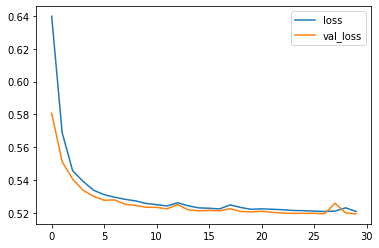

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
encoded = encoder.predict(img_arr)
decoded = conv_auto_encoder.predict(img_arr)

In [ ]:
print ('Low dimention shape: {}'.format(encoded[0].shape))
print ('output dimention shape: {}'.format(decoded[0].shape))

Low dimention shape: (28, 28, 32)
output dimention shape: (224, 224, 3)


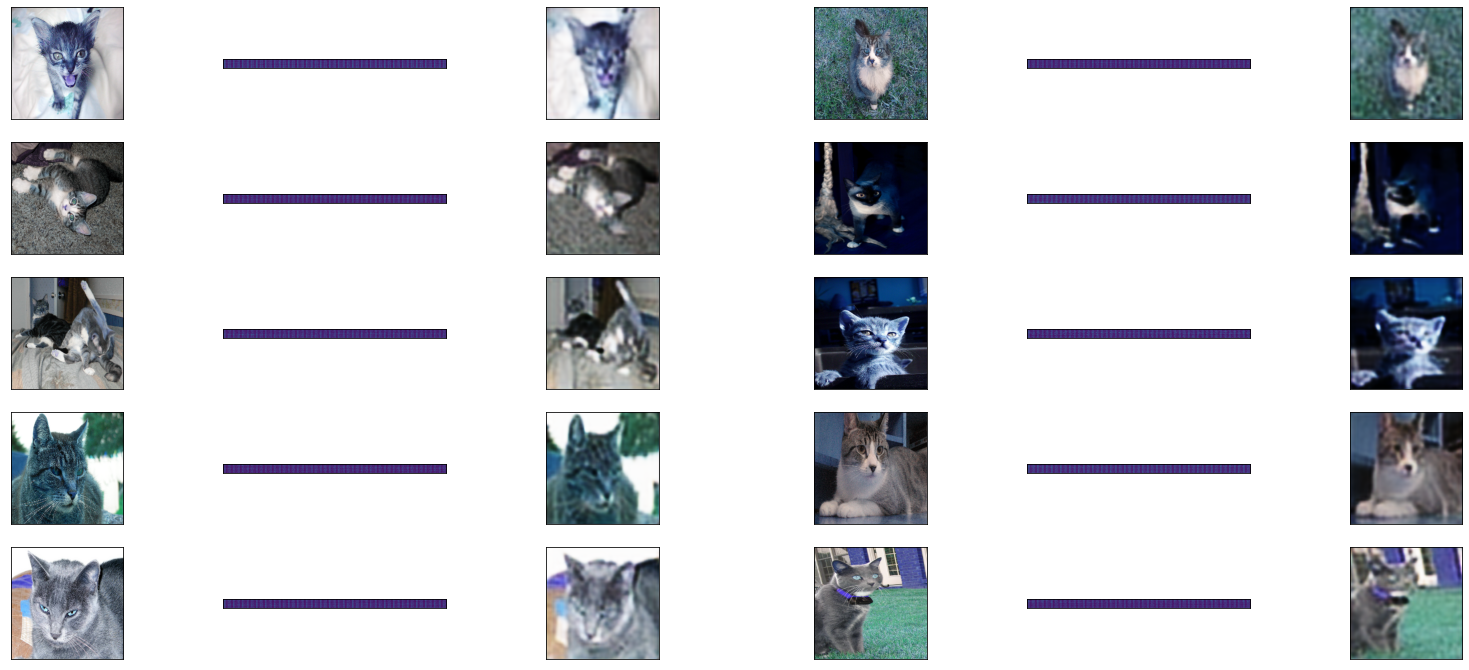

In [ ]:
fig = plt.figure(figsize=(28, 12))

n_plots = 10
n_row = int(n_plots / 2)

for j in range(n_plots):
    # Исходное входное значение（Input)
    fig.add_subplot(n_row, 6, 3*j+1)
    plot_tmp = plt.imshow(img_arr[j])
    plt.xticks([])
    plt.yticks([])
    
    # Низкоразмерный массив
    fig.add_subplot(n_row, 6, 3*j+2)
    plot_tmp = plt.imshow(encoded[j].reshape(32, 784))
    plt.xticks([])
    plt.yticks([])
    
    # Восстановленные исходные данные (Deconded)
    fig.add_subplot(n_row, 6, 3*j+3)
    plot_tmp = plt.imshow(decoded[j])
    plt.xticks([])
    plt.yticks([])
    
plt.show()

## Conv2DTranspose 

In [ ]:
input_layer = Input(shape=(img_arr.shape[1], img_arr.shape[2], img_arr.shape[3]))

x = Conv2D(filters=64, kernel_size=(3,3),
           padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

x = Conv2D(filters=32, kernel_size=(3,3),
           padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

x = Conv2D(filters=32, kernel_size=(3,3),
           padding='same', activation='relu')(x)
encoder_layer = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

x = Conv2D(filters=32, kernel_size=(3,3),
           padding='same', activation='relu')(encoder_layer)
x = Conv2DTranspose(filters=32,  kernel_size=(3,3),
                    strides=(2,2), padding='same',
                    use_bias=True, activation='relu')(x)
x = Conv2D(filters=32, ernel_size=(3,3),
           padding='same', activation='relu')(x)
x = Conv2DTranspose(filters=32, kernel_size=(3,3),
                    strides=(2,2), padding='same',
                    use_bias=True, activation='relu')(x)
x = Conv2D(filters=64, kernel_size=(3,3),
           padding='same', activation='relu')(x)
x = Conv2DTranspose(filters=64, kernel_size=(3,3),
                    strides=(2,2), padding='same',
                    use_bias=True, activation='relu')(x)
decoder_layer = Conv2D(filters=3, kernel_size=(3,3),
                       padding='same', activation='sigmoid')(x)

# Создание Convolutional AutoEncoder
conv_auto_encoder = Model(input_layer, decoder_layer)

# Настройка Encoder
encoder = Model(input_layer, encoder_layer)

In [ ]:
conv_auto_encoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 28, 28, 32)        0   

In [ ]:
conv_auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
callbacks = EarlyStopping(monitor='val_loss',
                          patience=11,
                          restore_best_weights=True)

In [ ]:
history = conv_auto_encoder.fit(img_arr, img_arr,
                                epochs=30, batch_size=64,
                                validation_split=0.3,
                                shuffle=True,
                                callbacks=[callbacks])

Epoch 1/30
19/19 [==============================] - 18s 943ms/step - loss: 0.6690 - val_loss: 0.5995
Epoch 2/30
19/19 [==============================] - 17s 923ms/step - loss: 0.5893 - val_loss: 0.5625
Epoch 3/30
19/19 [==============================] - 17s 923ms/step - loss: 0.5544 - val_loss: 0.5458
Epoch 4/30
19/19 [==============================] - 17s 918ms/step - loss: 0.5444 - val_loss: 0.5413
Epoch 5/30
19/19 [==============================] - 20s 1s/step - loss: 0.5408 - val_loss: 0.5387
Epoch 6/30
19/19 [==============================] - 17s 922ms/step - loss: 0.5393 - val_loss: 0.5458
Epoch 7/30
19/19 [==============================] - 20s 1s/step - loss: 0.5391 - val_loss: 0.5360
Epoch 8/30
19/19 [==============================] - 17s 920ms/step - loss: 0.5365 - val_loss: 0.5349
Epoch 9/30
19/19 [==============================] - 17s 920ms/step - loss: 0.5356 - val_loss: 0.5342
Epoch 10/30
19/19 [==============================] - 17s 921ms/step - loss: 0.5352 - val_loss: 0.

In [ ]:
encoded = encoder.predict(img_arr)
decoded = conv_auto_encoder.predict(img_arr)

In [ ]:
print ('encoded img shape {}'.format(encoded.shape))
print ('decoded img shape {}'.format(decoded.shape))

encoded img shape (1706, 28, 28, 32)
decoded img shape (1706, 224, 224, 3)


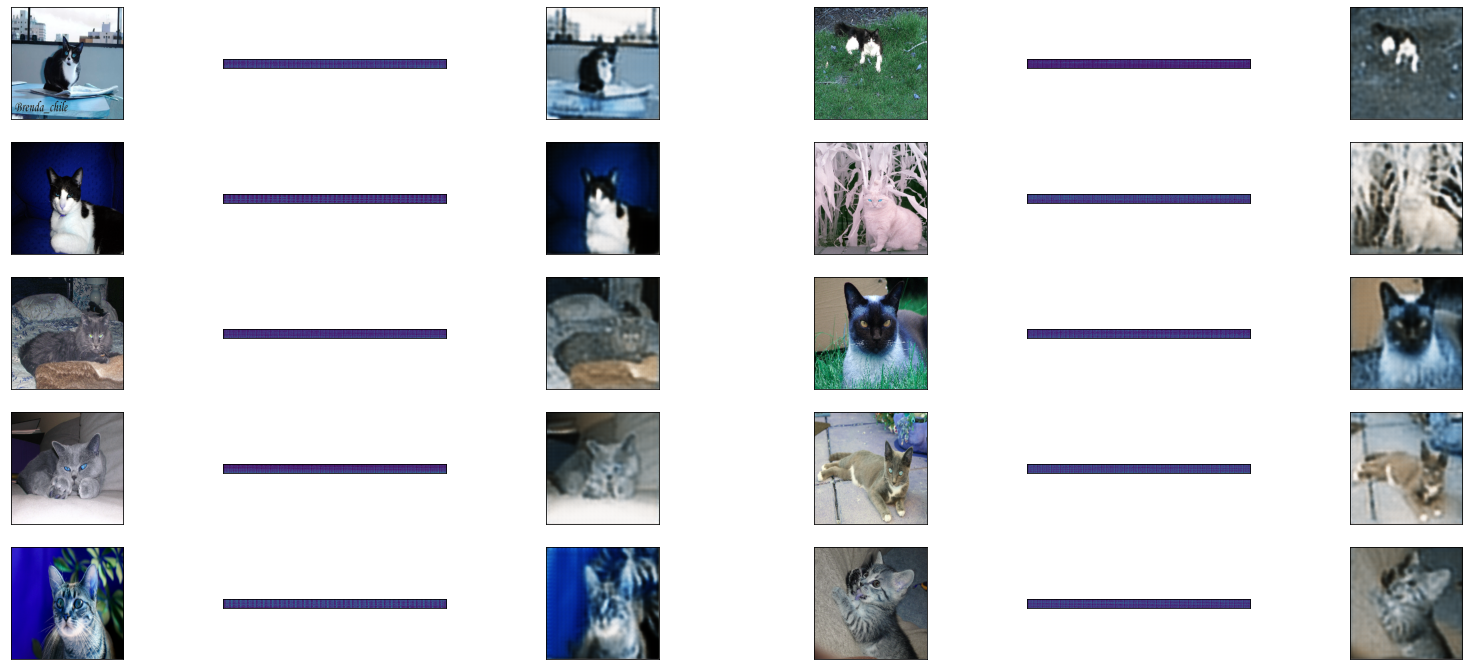

In [94]:
fig = plt.figure(figsize=(28, 12))

n_plot = 10
n_rows = int(n_plot / 2)
next = 30
for j in range(n_plot):
    fig.add_subplot(n_rows, 6, 3*j+1)
    plot_tmp = plt.imshow(img_arr[j+next])
    plt.xticks([])
    plt.yticks([])
    
    fig.add_subplot(n_rows, 6, 3*j+2)
    plot_tmp = plt.imshow(encoded[j+next].reshape(32, 784))
    plt.xticks([])
    plt.yticks([])
    
    fig.add_subplot(n_rows, 6, 3*j+3)
    plot_tmp = plt.imshow(decoded[j+next])
    plt.xticks([])
    plt.yticks([])